### Max-Cut Problem

The Max-Cut problem aims to partition the vertices of a graph into two sets such that the sum of the weights of the edges between the sets is maximized. Mathematically, given a graph $G = (V, E)$ with a weight matrix $W$, the objective is to maximize the cut value:

$$
\text{Maximize} \quad \sum_{(i,j) \in E} w_{ij} (1 - x_i x_j)
$$

where $x_i \in \{1, -1\}$ indicates the set to which vertex $i$ belongs.

### QAOA Algorithm

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid quantum-classical algorithm designed to find approximate solutions to combinatorial optimization problems like Max-Cut. The QAOA algorithm uses a parameterized quantum circuit consisting of alternating layers of problem and mixer unitaries.

1. **Problem Unitary:**
   The problem unitary $U(C, \gamma)$ encodes the problem's objective function into the quantum state. For Max-Cut, it can be expressed as:

   $$
   U(C, \gamma) = \exp \left( -i \gamma \sum_{(i,j) \in E} w_{ij} Z_i Z_j \right)
   $$

2. **Mixer Unitary:**
   The mixer unitary $U(B, \beta)$ drives the evolution of the quantum state, allowing it to explore the solution space. It is given by:

   $$
   U(B, \beta) = \exp \left( -i \beta \sum_{i \in V} X_i \right)
   $$

3. **QAOA State:**
   The QAOA state after $p$ layers of alternating problem and mixer unitaries is:

   $$
   |\psi(\beta, \gamma)\rangle = U(B, \beta_p) U(C, \gamma_p) \ldots U(B, \beta_1) U(C, \gamma_1) H^{\otimes n} |0\rangle^{\otimes n}
   $$

4. **Expectation Value:**
   The goal is to find parameters $\beta$ and $\gamma$ that maximize the expectation value of the objective function:

   $$
   \langle \psi(\beta, \gamma) | C | \psi(\beta, \gamma) \rangle
   $$


Below is an implementaion of Maxcut Optimization.

In [1]:
# Import necessary libraries
from qiskit import transpile
import networkx as nx
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_optimization.applications import Maxcut
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

%matplotlib inline

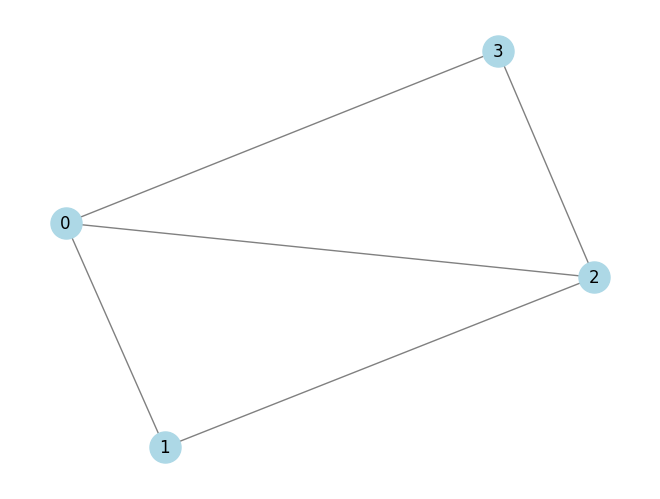

In [2]:
# Define the graph for the Max-Cut problem
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.show()

In [3]:
# Get the weight matrix of the graph
w = nx.adjacency_matrix(G).todense()

In [4]:
# Define QAOA parameters
num_qubits = len(G.nodes)
p = 1  # Number of QAOA layers
beta = Parameter('β')
gamma = Parameter('γ')

In [5]:
# Create the QAOA circuit
qaoa_circuit = QuantumCircuit(num_qubits)

In [6]:
# Initialize in superposition
for i in range(num_qubits):
    qaoa_circuit.h(i)

In [7]:
# Problem unitary
for u, v in G.edges:
    qaoa_circuit.cx(u, v)
    qaoa_circuit.rz(2 * gamma, v)
    qaoa_circuit.cx(u, v)

In [8]:
# Mixer unitary
for i in range(num_qubits):
    qaoa_circuit.rx(2 * beta, i)

In [9]:
# Measure the qubits
qaoa_circuit.measure_all()

In [10]:
# Bind the parameters using assign_parameters
param_values = {beta: np.pi/4, gamma: np.pi/4}
bound_circuit = qaoa_circuit.assign_parameters(param_values)

In [11]:
# Transpile the circuit for the simulator
simulator = AerSimulator()
compiled_circuit = transpile(bound_circuit, simulator)

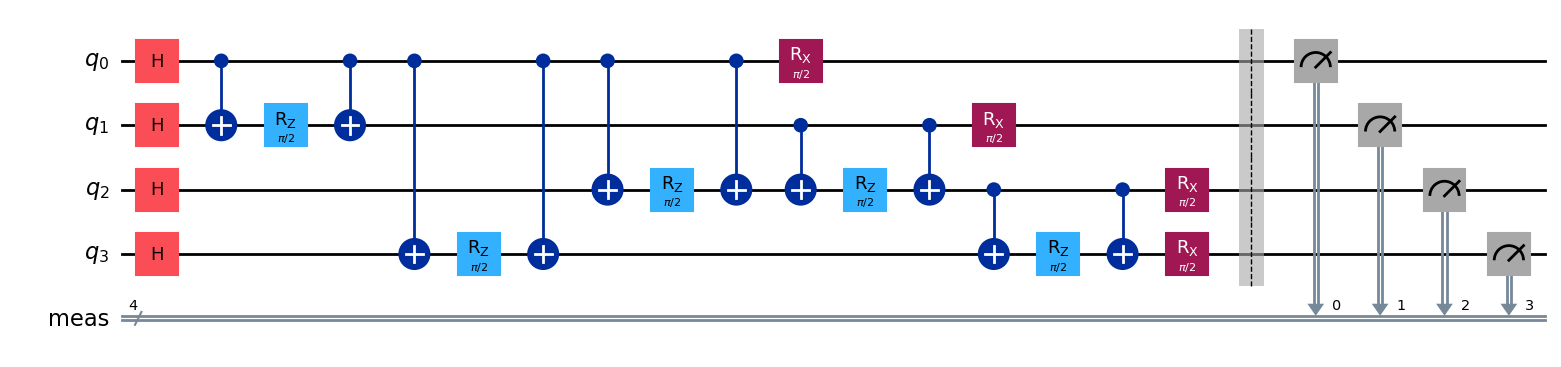

In [12]:
# Visualize the circuit
bound_circuit.draw('mpl')
plt.show()

In [13]:
# Simulate the circuit
result = simulator.run(compiled_circuit, shots=1000).result()
counts = result.get_counts()

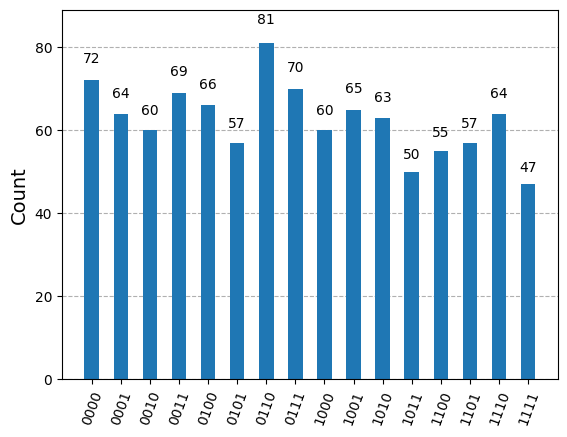

In [14]:
# Plot the results
plot_histogram(counts)
plt.show()

In [15]:
# Interpret the results
bitstrings = list(counts.keys())
max_cut_value = -np.inf
max_cut_solution = None

In [16]:
# Use the Maxcut class for evaluating the cut value
maxcut = Maxcut(w)
qp = maxcut.to_quadratic_program()

In [17]:
# Helper function to compute cut value
def compute_cut_value(bitstring, qp, num_nodes):
    binary_array = np.array([int(bit) for bit in bitstring])
    value = qp.objective.evaluate(binary_array)
    return value

In [18]:
# Evaluate each bitstring and find the optimal solution
for bitstring in bitstrings:
    cut_value = compute_cut_value(bitstring, qp, num_qubits)
    if cut_value > max_cut_value:
        max_cut_value = cut_value
        max_cut_solution = bitstring

In [19]:
# Display the optimal cut value and solution
print("Optimal cut value:", max_cut_value)
print("Optimal cut solution:", max_cut_solution)

Optimal cut value: 4.0
Optimal cut solution: 1010


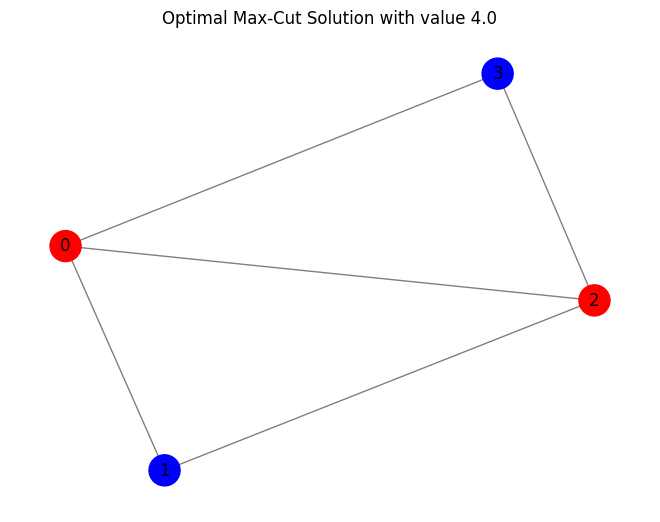

In [20]:
# Visualize the optimal solution
colors = ['red' if bit == '1' else 'blue' for bit in max_cut_solution]
nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=500)
plt.title(f"Optimal Max-Cut Solution with value {max_cut_value}")
plt.show()